### Data Cleaning

In [ ]:
# !pip install pandas
# !pip install deepmultilingualpunctuation protobuf
# !pip install sentencepiece
# https://huggingface.co/oliverguhr/fullstop-punctuation-multilang-large
# !pip install nltk

In [45]:
import pandas as pd
import re
import csv
from deepmultilingualpunctuation import PunctuationModel
import nltk
import matplotlib.pyplot as plt

### Analyze Common Words

Analyze what the most common words to find phrases we should remove

In [ ]:
# Download the following nltk data if not done already
# nltk.download('punkt')
# nltk.download('stopwords')

In [64]:
import string
import pandas as pd

In [67]:
EXPECTED_WORDS = ['body', 'feel', 'breathe', 'life', 'love', 'energy', 
                  'heart', 'time', 'mind', 'feeling']

def get_freq_dist(csv_file_path):
    df = pd.read_csv(csv_file_path, encoding='utf8')
    script = ''
    # Only consider text from the Scripts
    for idx, item in df.iterrows():
        s = item['Script']
        script += s.lower()  # lower case everything
    print('Loaded text')

    text = ''
    # Remove punctuation marks
    for char in script:
        for j in list(string.punctuation):
            char = char.replace(j,'').lower()
        text += char
    print('Removed punctuation marks')

    all_words = nltk.tokenize.word_tokenize(text)
    # all_word_dist = nltk.FreqDist(w.lower() for w in all_words)  # Frequency Distribution

    stopwords = nltk.corpus.stopwords.words('english')
    no_stopwords_dist = nltk.FreqDist(w for w in all_words if w.isalpha() and w not in stopwords and w not in EXPECTED_WORDS)
    print('Got Frequency Distribution')
    return no_stopwords_dist

In [68]:
csv_file_path = 'med-transcript-dataset.csv'
no_stopwords_dist = get_freq_dist(csv_file_path)

Loaded text
Removed punctuation marks
Got Frequency Distribution


In [71]:
common_words_no_stops = no_stopwords_dist.most_common(20)#.keys()
common_words_no_stops = dict(common_words_no_stops)
print(common_words_no_stops)

{'go': 28919, 'breath': 27264, 'let': 24395, 'back': 23585, 'right': 22109, 'like': 20583, 'take': 20551, 'one': 18618, 'moment': 17554, 'youre': 16696, 'see': 16438, 'know': 16347, 'way': 15081, 'every': 14202, 'allow': 13163, 'want': 12524, 'thank': 12490, 'day': 12390, 'notice': 12326, 'come': 12154}


<Axes: >

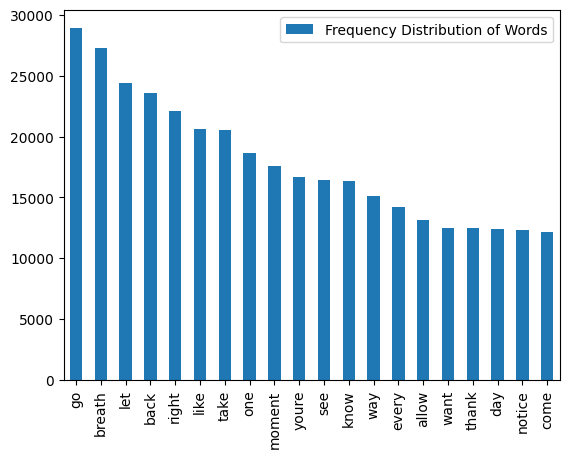

In [72]:
# plot
df = pd.DataFrame(
    {'Frequency Distribution of Words':list(common_words_no_stops.values())},
    index=list(common_words_no_stops.keys())
)
df.plot(kind='bar')
# plt.hist(common_words_no_stops)
# plt.bar(common_words_no_stops.keys(), common_words_no_stops.values())

### Data Cleaning

In [43]:
# INSIGHT_DATA_FILE = 'insight-transcripts-data.csv'
INSIGHT_DATA_FILE = 'insight-transcripts-data-cleaned.csv'
YOUTUBE_DATA_FILE = 'yt-transcripts-data.csv'

In [3]:
model = PunctuationModel()

/home/petern/miniconda3/envs/web_scrape/lib/python3.11/site-packages/transformers/pipelines/token_classification.py:169: UserWarning: `grouped_entities` is deprecated and will be removed in version v5.0.0, defaulted to `aggregation_strategy="AggregationStrategy.NONE"` instead.
  warnings.warn(


In [42]:
# Common intros to remove
PHRASES_TO_REMOVE = [
    r'.*welcome to carries conscious living are you ready to',
    r'.*on the 7th of this month are you ready to',
    r'.*are (you|we) ready to meditate (with|the)',
    r'.*join the patreon the links are in the description',
    r'.*if you are returning welcome back here at the',
    r".*I'm Sara Raymond here at the mindful movement",
    r'.*your host Brian Scott',
    r'.*create your free Mindvalley account today at mindvalley.com'
]

def data_clean(csv_file_path):
    cleaned_file_name = csv_file_path.rstrip('.csv')
    cleaned_file_name += '-cleaned.csv'

    df = pd.read_csv(csv_file_path, encoding='utf8')
    # df.dropna()

    with open(cleaned_file_name, 'a', encoding='utf8', newline='') as csvf:
        writer = csv.writer(csvf)
        # if csvf empty
        # writer.writerow(['Meditation_Type','URL','Script'])
        for idx, item in df.iterrows():
            s = item['Script']
            s = re.sub('\[.*?\]', ' ', s)  # Remove content inside square brackets
            s = re.sub('\(.*?\)', ' ', s)  # Remove contents inside square brackets
            s = re.sub('\s+',' ', s)  # Replace consecutive whitespace with a single space

            # Remove specific phrases  (FOR youtube data)
            s = re.sub('so( so)+', 'so', s)  # Remove consecutive 'so'
            s = re.sub('foreign( foreign)+', 'foreign', s)  # Remove consecutive 'foreign' 
            s = re.sub('you( you)+', 'you', s)  # Remove consecutive 'you'

            # Remove the unrelated introductions
            s = re.sub(".*let's (begin|start)", "let's start", s)
            s = re.sub(".*(begin|start) by", 'start by', s)
            for phrase in PHRASES_TO_REMOVE:
                s = re.sub(phrase, '', s)

            # Add Punctuation
            s = model.restore_punctuation(s)  # Takes very long time

            script = s
            url = item['URL']
            med_type = item['Meditation_Type']
            writer.writerow([med_type, url, script])
            print(f"Done Line {idx + 2}")  # Account for 0 index and the header line

    print(f'Written cleaned data to {cleaned_file_name}')

In [ ]:
data_clean(YOUTUBE_DATA_FILE)  # ADD -cleaned file??m

In [ ]:
data_clean(INSIGHT_DATA_FILE)

In [ ]:
# After adding punctuation, grep for lines that don't end with period

# Remove all instances of . you. and you" using find and replace
# Do the same with foreign  (also very common in youtube scripts)
# (youtube transcripts have a bunch of random you.)